In [46]:
# SimpleWPGen_Coax
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Weighting Potential solver for a coaxial HPGe detector via SOR method
#  - Disclaimer: for demonstration/example purposes only!
#
#  - 2D, radial symmetry around core

In [47]:
%matplotlib inline
%reset -f

In [48]:
import numpy as np
from matplotlib import pyplot as plt

In [63]:
# set some detector parameters
detector_length_mm = 90.0
detector_radius_mm = 40.0
pixel_size_mm = 1.0

core_length_mm = 60.0
core_radius_mm = 5.0

wrap_around_mm = 0.0

outer_contact_bias = 0.0
core_contact_bias = 1.0


In [64]:
# build (uniform) 2D grids for plotting and solving
x_range = np.arange(0, detector_radius_mm + pixel_size_mm, pixel_size_mm)
y_range = np.arange(0, detector_length_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

# XY mesh for plotting later
X, Y = np.meshgrid(y_range, x_range)

In [65]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 outer contact = 1 core = 2 passivated face = 3
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# outer contact
geom_map[(N_xelements-1),:] = 1
geom_map[:,(N_yelements-1)] = 1

# outer contact wrap around
ix = np.where(x_range>=(detector_radius_mm-wrap_around_mm))
geom_map[ix,0] = 1


In [66]:
pixels_to_cm = 10/pixel_size_mm

for x in range(0, N_xelements):
    for y in range(0, N_yelements):        
        # core
        if (x_range[x]<core_radius_mm and y_range[y]<core_length_mm):
            geom_map[x,y] = 2


In [67]:
# set boundary conditions and initial guess at solution

# initial guess at solution 

# outer contact
x,y = np.where(geom_map==1)
V[x,y] = outer_contact_bias

# core
x,y = np.where(geom_map==2)
V[x,y] = core_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

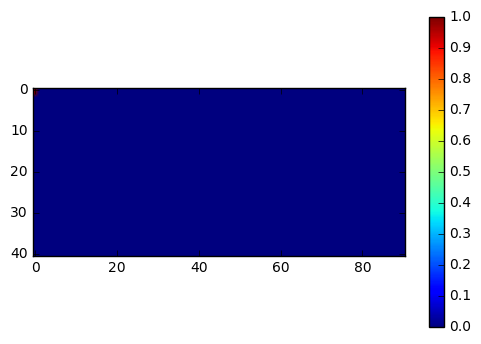

In [68]:
# inspect initial conditions for V
plt.imshow(V)
plt.colorbar()

In [69]:
# do the relaxation to solve

# set maximum number of iterations
max_iters = 1000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01
while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(0, N_yelements):
        for x in range(0, N_xelements):
                        
            # skip non-Ge pixels
            if (geom_map[x,y] != 0):
                continue
                
            # deal with reflection symmetry at x=0
            if (x == 0):
                V_local_sum = (V[x,y-1] + V[x,y+1] + 2.0*V[x+1,y])
                
            elif (y == 0):
                V_local_sum = (V[x-1,y] + V[x+1,y] + 2.0*V[x,y+1])
            
            # all other cases
            else:                                
                V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

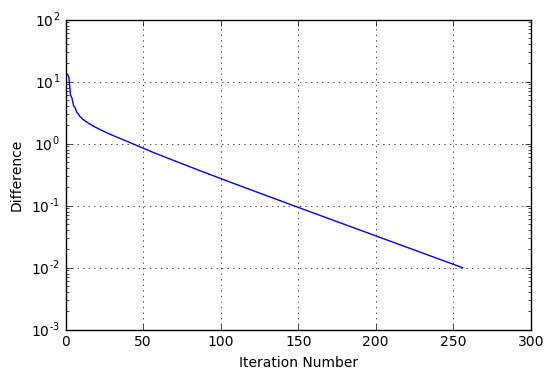

Final Difference:
0.009924147506


In [70]:
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
#plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

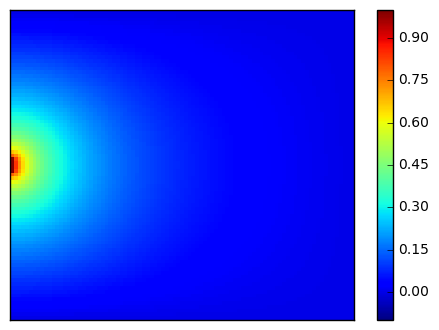

In [71]:
# apply mirror symmetry around x = 0 to create a full potential map
Vfinal = np.flipud(V)
Vfinal = np.append(Vfinal, V, axis=0)

# plot the computed weighting potential
plt.imshow(Vfinal, interpolation="None", cmap="jet", vmin=-0.1)
plt.xticks([])
plt.yticks([])
plt.colorbar()

<function matplotlib.pyplot.show>

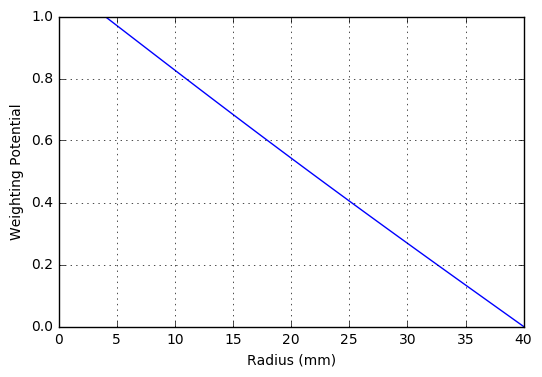

In [58]:
# take a slice through the WP
#plt.contourf(X,Y,V, 30)
#plt.show()
WPslice = V[:,30]

plt.plot(x_range, WPslice)
plt.grid("on")
plt.xlabel("Radius (mm)")
plt.ylabel("Weighting Potential")
plt.show